In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
#from sklearn.metrics import plot_roc_curve
from scipy import interp
#from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import pandas as pd
from sklearn.linear_model import Perceptron


Xtest = np.loadtxt("Xtest.csv", delimiter=' ')
Xtrain = np.loadtxt("Xtrain.csv", delimiter=' ' )
Ytrain = np.loadtxt("Ytrain.csv", delimiter=' ')

ImportError: cannot import name 'accuracy_score'

In [208]:
## ROC-AUC, accuracy and AUC-PR metrics in one

def evaluation_metrics(X, classifier, print_summary = True):
    roc =[]
    pr = []
    accuracy = []
    all_vals = []
    for i, (train, test) in enumerate(skf.split(X, Ytrain)):
        classifier.fit(X[train], Ytrain[train])
        roc_score = roc_auc_score(Ytrain[test], classifier.predict(X[test]))
        pr_score = average_precision_score(Ytrain[test], classifier.predict(X[test]))
        accuracy_score = np.mean(Ytrain[test] == classifier.predict(X[test]))
        
        roc.append(roc_score)
        pr.append(pr_score)
        accuracy.append(accuracy_score)
        all_vals.append({'roc_score':roc_score,'pr_score':pr_score,'accuracy':accuracy_score})
    avg = []
    tmp_avg =0.0
    for v in all_vals:
        tmp_avg += ['roc']
    %divide vy number of values
    if print_summary == True:
        print(roc)
        print("AUC-ROC: %0.2f (+/- %0.2f)" % (np.mean(roc), np.std(roc) * 2))
        print(pr)
        print("AUC-PR: %0.2f (+/- %0.2f)" % (np.mean(pr), np.std(pr) * 2))
        print(accuracy)
        print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(accuracy), np.std(accuracy) * 2))
        
    return(all_vals)
    

i) 

There are 3000 rows (images) of training data with corespoinding 3000 labels. 

In [2]:
print(Xtrain.shape)
print(Ytrain.shape)

(3000, 784)
(3000,)


The images depict clothing, shoes, purses. The classification rule is not clear for me.

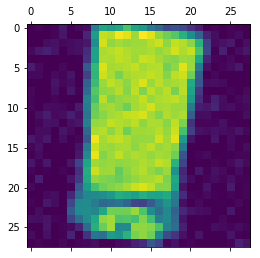

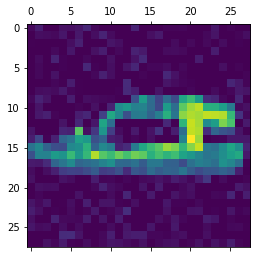

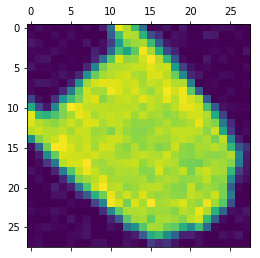

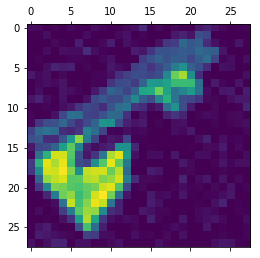

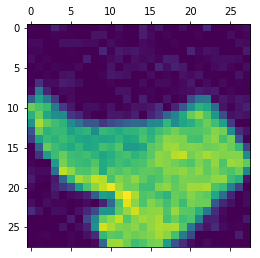

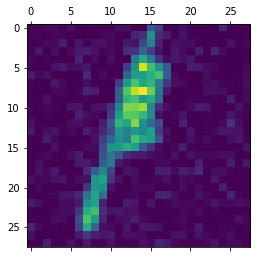

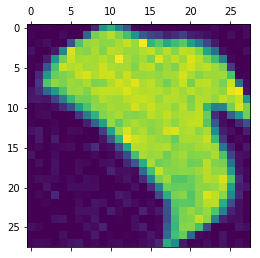

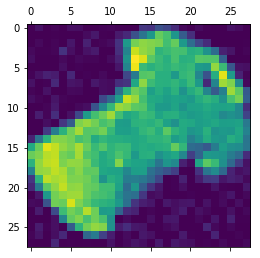

In [203]:
pos = Xnormalized[Ytrain == 1]
neg = Xnormalized[Ytrain == -1]
for i in range(10,14): 
    image_pos = np.reshape(pos[i], (28,28))
    image_neg = np.reshape(neg[i], (28,28))
    plt.matshow(image_pos)
    plt.matshow(image_neg)

ii) 

There are 1821 negatives and 1179 positive labels. Thus, the data is moderately imbalanced with a rough 60/40 split (dominated by negatives).

In [16]:
np.unique(Ytrain, return_counts=True)

(array([-1.,  1.]), array([1821, 1179]))

iii)


Due to the imbalance of the data, accuracy seems to be not the most appropriate performace evaluation tool owing to its bias toward the dominant category. Thus, AUC-ROC or AUC-PR are prefered options. The choice among these two metrics depends on the severity of the imbalance and the weight we put on correctly predicting the positive class (and thus precision). Since (1) the skew of the data is not severe (60/40), (2) no information is given about the goals of prediction and the fact that (3) the nature of the data (clothing) does not suggest that False Positives or False Negatives are more costly, I decided to use AUC-ROC as the performace evaluation metric. 

iv)

In general, a random classifier is expected to predict 50% of the labels correctly, yet we could derive a slightly more sphisticated expectation of the random classifier which would allow to incorporate different rates of predicting a certain group (predicting everything is of one class is as random as predicting 50/50 split). Accuracy is defined as a ratio of correctly labeled instances (True positives + True negetives) to the total population. To calculate expected confussion matrix terms, let's define $q$ as a probability that a random classifier assigns a positive label to a random input. In addition, recall that our traiingn data has 60% of negative and 40% of positive indtances. Then the expected proportions of all the confussion matrix terms are:

$TP = 0.4q \\
TN = (1-q)0.6 \\
FP = 0.6q\\
FN = (1-q)0.4$

Hence the expected accuracy of a random classifier is $TP+TN = 0.6-0.2q$, which for $q=0.5$ results in accuracy being 50%. 

v)

AUC-ROC curve is defined as the are under the true positive rate (TPR) against the false positive rate (FPR) curve. 

$TPR = \frac{TP}{FN+TP}= \frac{0.4q}{(1-q)0.4+0.4}=q \\
FPR = \frac{FP}{FP+TN}= \frac{0.6q}{(1-q)0.6+0.6}=q$

Hence the expectation of TPR over the range of FPR is:

$\int_0^1qdq=\frac{q^2}{2}|_0^1=1/2$

And since the expected AUC-ROC does not depend on the proportion of the data, the same result holds for the testing data.

AUC-PR, on the other hand is defined as the are under the precisiona against TPR curve. For the testing data is follows that:

$Precision = \frac{TP}{TP+FP}=\frac{0.4q}{0.4q+0.6q}=0.4$

Hence the expected training AUC-PR is

$\int_0^10.4qd=0.4q|_0^1 = 0.4$

By the same reasoning, it follows that expected random classifier AUC-PR for the testing data would be equal to the proportion of positive items in a data.

## Question 2
### i)

In [210]:
sknn = KNeighborsClassifier(n_neighbors=1)

skf = StratifiedKFold(n_splits=5)

# function that gives accuracy after fitting the model via cross validation
scores = cross_val_score(sknn, Xtrain, Ytrain, cv=skf)

In [211]:
# Accuracy summary
print(scores)

[0.77703827 0.75333333 0.74166667 0.75833333 0.73789649]


NameError: name 'plot_roc_curve' is not defined

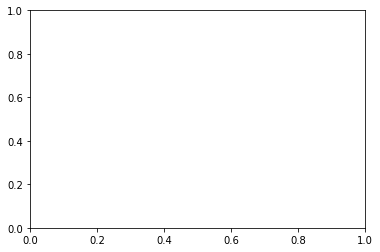

In [8]:
# AUC-ROC for each fold
aucs = []

fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(Xtrain, Ytrain)):
    sknn.fit(Xtrain[train], Ytrain[train])
    # requires sklearn 22.1
    viz = plot_roc_curve(sknn, Xtrain[test], Ytrain[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    aucs.append(viz.roc_auc)
    
# NOTE: If you do not have sklearn 22.0 pr highre, use this one instead:

ROC_AUC(Xtrain, sknn)

In [84]:

# AUC-PR curve
# requires sklearn 22.1
fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(Xtrain, Ytrain)):
    sknn.fit(Xtrain[train], Ytrain[train])
    viz = plot_precision_recall_curve(sknn, Xtrain[test], Ytrain[test],
                         name='PR fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)



[]

In [212]:
base_scores = evaluation_metrics(Xtrain, sknn)

[0.7685163687021127, 0.7400819519463588, 0.7394067796610169, 0.7576131495623021, 0.727788169277531]
AUC-ROC: 0.75 (+/- 0.03)
[0.624488904540898, 0.5942294954217806, 0.5833051921548409, 0.6032864300181217, 0.5753581448243409]
AUC-PR: 0.60 (+/- 0.03)
[0.7770382695507487, 0.7533333333333333, 0.7416666666666667, 0.7583333333333333, 0.7378964941569283]
Accuracy: 0.75 (+/- 0.03)


### ii)



In [231]:
# Mean of the evaluation metrics
base_scores = pd.DataFrame(base_scores)
base_scores.mean(axis = 0)

accuracy     0.753654
pr_score     0.596134
roc_score    0.746681
dtype: float64

In [234]:
# Standard deviation of each measure
base_scores.std(axis = 0)

accuracy     0.015499
pr_score     0.019072
roc_score    0.016200
dtype: float64

### iii)

I will implement the following transformations: scaling, scaling to a range (between 0:1 and -1:1), mapping to uniform and Gaussian distributions and normalization. Sparse data transformations will not be applied because the data is not sparse - all needed values are present. Robust scaling, albeit not neccesary due to the the abscence of strong outliers, will still be conducted to deduce the importance of extreme values.

In [193]:
# Scaling
scaling = preprocessing.StandardScaler().fit(Xtrain)
Xscaled = scaling.transform(Xtrain)

scaled_scores = evaluation_metrics(Xscaled, sknn)

,accuracy,pr_score,roc_score
0,0.742097,0.580324,0.730764
1,0.753333,0.594694,0.742317
2,0.771667,0.618666,0.766367
3,0.776667,0.625581,0.774958
4,0.756260,0.597406,0.745914


In [237]:
pd.DataFrame(scaled_scores)

,accuracy,pr_score,roc_score
0,0.742097,0.580324,0.730764
1,0.753333,0.594694,0.742317
2,0.771667,0.618666,0.766367
3,0.776667,0.625581,0.774958
4,0.756260,0.597406,0.745914


In [194]:
# MinMax Scaler
min_max_scaler = preprocessing.MinMaxScaler()
Xtrain_minmax = min_max_scaler.fit_transform(Xtrain)

minmax_scores = evaluation_mertics(Xtrain_minmax, sknn)
# AUC-ROC same as scaled, AUC-PR worse, accuracy -worse. Prefer scaled

[0.7615393545391222, 0.7387083255727324, 0.7401517973551872, 0.7589867759359284, 0.7270341360766893]
AUC-ROC: 0.75 (+/- 0.03)
[0.6158402242701907, 0.5922227880022308, 0.5835577230572433, 0.6052054442732409, 0.5751228110680922]
AUC-PR: 0.59 (+/- 0.03)
[0.7703826955074875, 0.7516666666666667, 0.7416666666666667, 0.76, 0.7378964941569283]
Accuracy: 0.75 (+/- 0.02)


In [196]:
# MaxAbs Scaler - must be centered at zero a priori

demeaning = preprocessing.StandardScaler(with_std=False).fit(Xtrain)
Xdemeaned = scaling.transform(Xtrain)
max_abs_scaler = preprocessing.MaxAbsScaler()
Xtrain_maxabs = max_abs_scaler.fit_transform(Xdemeaned)

maxabs_scores = evaluation_metrics(Xtrain_maxabs, sknn)
# worse than scaled in all the measures

[0.7470919433480381, 0.740826969640529, 0.7415254237288136, 0.7589867759359284, 0.7251753565583352]
AUC-ROC: 0.74 (+/- 0.02)
[0.5955656109873375, 0.5943792553962045, 0.5853704417051875, 0.6052054442732409, 0.5703701674884099]
AUC-PR: 0.59 (+/- 0.02)
[0.7537437603993344, 0.7533333333333333, 0.7433333333333333, 0.76, 0.7328881469115192]
Accuracy: 0.75 (+/- 0.02)


In [198]:
# Robust Scaling
robust_scaling = preprocessing.RobustScaler().fit(Xtrain)
Xrobust = robust_scaling.transform(Xtrain)

robust_scores = evaluation_metrics(Xrobust, sknn)
# worse in every measure than the scaled version

[0.710453912235895, 0.7526774073384243, 0.7318401937046004, 0.726462097224809, 0.741039279869067]
AUC-ROC: 0.73 (+/- 0.03)
[0.5584026443048812, 0.6091248999781771, 0.5824421972178703, 0.5735494864932866, 0.5912818941735043]
AUC-PR: 0.58 (+/- 0.03)
[0.7237936772046589, 0.765, 0.7433333333333333, 0.735, 0.7512520868113522]
Accuracy: 0.74 (+/- 0.03)


In [ ]:
# Uniform distribution transformation

quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
Xuniform = quantile_transformer.fit_transform(Xtrain)

uniform_scores = evaluation_metrics(Xuniform, sknn)
# same or slightly better than scaled. 

In [200]:
normal_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
Xnormal = normal_transformer.fit_transform(Xtrain)

normal_scores = evaluation_metrics(Xnormal, knn)
# worse than scaled or uniform 

[0.7465056884142094, 0.6956369901285155, 0.723225926615757, 0.7052523747439001, 0.7243920972644377]
AUC-ROC: 0.72 (+/- 0.04)
[0.5787239029241209, 0.5266328192599379, 0.5543087090928472, 0.5361873071990573, 0.5579640445056101]
AUC-PR: 0.55 (+/- 0.04)
[0.7321131447587355, 0.675, 0.7066666666666667, 0.6866666666666666, 0.7145242070116862]
Accuracy: 0.70 (+/- 0.04)


In [201]:
Xnormalized = preprocessing.normalize(Xtrain, norm='l2')

normalized_scores = evaluation_metrics(Xnormalized, knn)
# highest AUC-ROC, slightly lower accuracy than that of uniform.

[0.760697701416299, 0.741478860122928, 0.7773794002607562, 0.7474390016762898, 0.7677811550151976]
AUC-ROC: 0.76 (+/- 0.03)
[0.5983410344980976, 0.5779599102236669, 0.6136431385667558, 0.5804871964193998, 0.6038083866166132]
AUC-PR: 0.59 (+/- 0.03)
[0.7520798668885191, 0.7333333333333333, 0.7633333333333333, 0.7333333333333333, 0.7562604340567612]
Accuracy: 0.75 (+/- 0.02)


NOrmalisarion to have unit norm, scaling and mapping the data to uniform distribution seems to have led to the highest AUC-ROC score. However, only normalised training data managed to improve AUC-ROC score, which I hold to be the most approporiate measure. Thus, I will will focus on normalisation.

In [239]:
# creating odd list of K for KNN
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
cv_scores = []
cv_std = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    viz = evaluation_metrics(X = Xnormalized, classifier = knn, print_summary = True)
    #mean = viz[0]
    #std = viz[1]
    #cv_scores.append((k, mean))
    #cv_std.append((k, std))

[0.7838576735546784, 0.7641320543862917, 0.7550987148444777, 0.7497671819705717, 0.7205693242927286]
AUC-ROC: 0.75 (+/- 0.04)
[0.6323624876565647, 0.6183235328029516, 0.596700116257725, 0.5965418473262383, 0.5624424504561613]
AUC-PR: 0.60 (+/- 0.05)
[0.7820299500831946, 0.7716666666666666, 0.7516666666666667, 0.7533333333333333, 0.7245409015025042]
Accuracy: 0.76 (+/- 0.04)
[0.7494659856048294, 0.7679735518718569, 0.7615710560625816, 0.7451341031849508, 0.742331073182137]
AUC-ROC: 0.75 (+/- 0.02)
[0.5946868213993627, 0.6171805736636244, 0.6015744870651205, 0.5879339676138869, 0.5856690391082751]
AUC-PR: 0.60 (+/- 0.02)
[0.7520798668885191, 0.77, 0.755, 0.745, 0.7445742904841403]
Accuracy: 0.75 (+/- 0.02)
[0.777629440445786, 0.7520022350530825, 0.7755401378282734, 0.7522350530825108, 0.762719195697919]
AUC-ROC: 0.76 (+/- 0.02)
[0.6241290679355369, 0.5971751412429378, 0.6173877490336008, 0.594384923089612, 0.6079973782076241]
AUC-PR: 0.61 (+/- 0.02)
[0.7753743760399334, 0.753333333333333

[0.7635825400510796, 0.746763829390948, 0.7521419258707394, 0.7586142670888433, 0.7579494973111994]
AUC-ROC: 0.76 (+/- 0.01)
[0.5935236373948811, 0.5735073246337684, 0.5806009244992295, 0.5855036271855046, 0.5870417922651139]
AUC-PR: 0.58 (+/- 0.01)
[0.7437603993344426, 0.7216666666666667, 0.73, 0.7333333333333333, 0.7378964941569283]
Accuracy: 0.73 (+/- 0.01)
[0.7581030879962851, 0.746135220711492, 0.7556341963121624, 0.757869249394673, 0.7614507832592939]
AUC-ROC: 0.76 (+/- 0.01)
[0.5869352784006829, 0.5723451283576172, 0.5841345659989727, 0.5851594027441486, 0.590671669204191]
AUC-PR: 0.58 (+/- 0.01)
[0.7371048252911814, 0.72, 0.7333333333333333, 0.7333333333333333, 0.7412353923205343]
Accuracy: 0.73 (+/- 0.01)


In [241]:
pd.DataFrame(viz)

,accuracy,pr_score,roc_score
0,0.737105,0.586935,0.758103
1,0.720000,0.572345,0.746135
2,0.733333,0.584135,0.755634
3,0.733333,0.585159,0.757869
4,0.741235,0.590672,0.761451


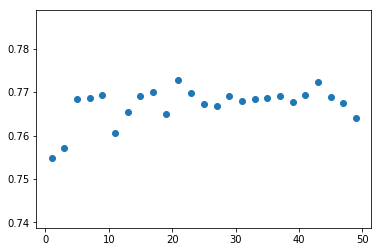

In [65]:
plt.scatter(*zip(*cv_scores))
plt.show()

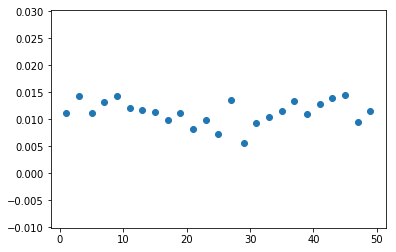

In [61]:
zip(*cv_std)
plt.scatter(*zip(*cv_std))
plt.show()

In [66]:
# creating odd list of K for KNN
neighbors = list(range(50, 100, 2))

# empty list that will hold cv scores
cv_scores_next = []
cv_std_next = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    viz = ROC_AUC(X = Xuniform, classifier = knn, print_summary = False)
    mean = viz[0]
    std = viz[1]
    cv_scores_next.append((k, mean))
    cv_std_next.append((k, std))

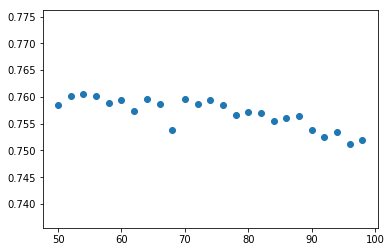

In [71]:
plt.scatter(*zip(*cv_scores_next))
plt.show()

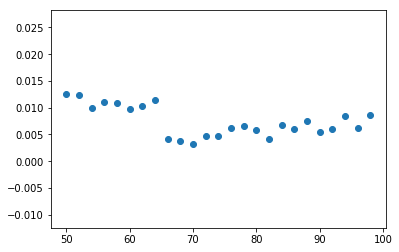

In [72]:
zip(*cv_std)
plt.scatter(*zip(*cv_scores_next))
plt.show()

In [115]:
# creating odd list of K for KNN
neighbors = list(range(20, 45, 1))

# empty list that will hold cv scores
cv_scores_zoom = []
cv_std_zoom = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    viz = ROC_AUC(X = Xuniform, classifier = knn, print_summary = False)
    mean = viz[0]
    std = viz[1]
    cv_scores_zoom.append((k, mean))
    cv_std_zoom.append((k, std))

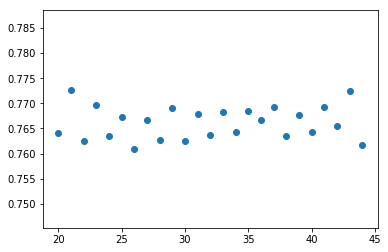

In [116]:
plt.scatter(*zip(*cv_scores_zoom))
plt.show()

In [126]:
cv_std_zoom
# 21st the best

[(20, 0.010475502401999697),
 (21, 0.008144282653055855),
 (22, 0.009563560396416149),
 (23, 0.00986283024825243),
 (24, 0.008823242692146824),
 (25, 0.007218981748785588),
 (26, 0.012133579418002608),
 (27, 0.013547552747862145),
 (28, 0.009644588530466543),
 (29, 0.005564557531598123),
 (30, 0.008889237596079394),
 (31, 0.009290194492111352),
 (32, 0.013327697903083895),
 (33, 0.01051359842599518),
 (34, 0.011533372819967323),
 (35, 0.011553651147814393),
 (36, 0.010098831295110054),
 (37, 0.013482281357765583),
 (38, 0.013087791671488425),
 (39, 0.011071717632906892),
 (40, 0.008803935868576307),
 (41, 0.012849555966456929),
 (42, 0.014179632528937424),
 (43, 0.013906264499659206),
 (44, 0.011924178178768867)]

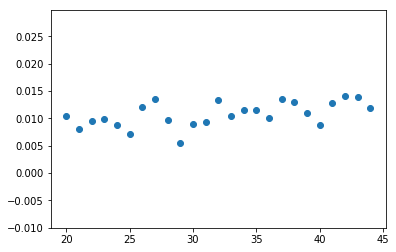

In [117]:
plt.scatter(*zip(*cv_std_zoom))
plt.show()

In [119]:
# creating odd list of K for KNN
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
cv_scores_scaled = []
cv_std_scaled = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    viz = ROC_AUC(X = Xscaled, classifier = knn, print_summary = False)
    mean = viz[0]
    std = viz[1]
    cv_scores_scaled.append((k, mean))
    cv_std_scaled.append((k, std))

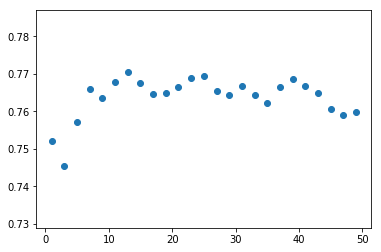

In [120]:
plt.scatter(*zip(*cv_scores_scaled))
plt.show()

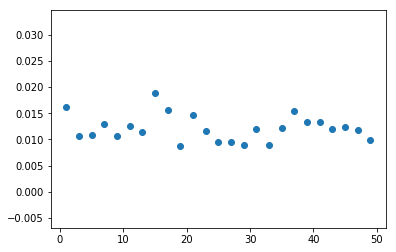

In [121]:
plt.scatter(*zip(*cv_std_scaled))
plt.show()

In [122]:
cv_scores_scaled

[(1, 0.7520640540416859),
 (3, 0.7453692579446795),
 (5, 0.7571982174838239),
 (7, 0.7660441126583576),
 (9, 0.7636506032585892),
 (11, 0.767793573695816),
 (13, 0.7705385684271121),
 (15, 0.7676107675033965),
 (17, 0.7646840170090298),
 (19, 0.7649348655089432),
 (21, 0.766477171021678),
 (23, 0.7690190889884114),
 (25, 0.7693454894156622),
 (27, 0.7654276870593455),
 (29, 0.7644071914184645),
 (31, 0.7668056723076261),
 (33, 0.7644865072485868),
 (35, 0.7621933198230567),
 (37, 0.7665075080726987),
 (39, 0.7686287079138152),
 (41, 0.7667873448940637),
 (43, 0.7649362136956552),
 (45, 0.7605732038241709),
 (47, 0.7591752452182529),
 (49, 0.7598187157087068)]

In [123]:
# creating odd list of K for KNN
neighbors = list(range(11, 16, 1))

# empty list that will hold cv scores
cv_scores_scaled_zoom = []
cv_std_scaled_zoom = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    viz = ROC_AUC(X = Xscaled, classifier = knn, print_summary = False)
    mean = viz[0]
    std = viz[1]
    cv_scores_scaled_zoom.append((k, mean))
    cv_std_scaled_zoom.append((k, std))

In [124]:
cv_scores_scaled_zoom

[(11, 0.767793573695816),
 (12, 0.7609688191312118),
 (13, 0.7705385684271121),
 (14, 0.7659808664972697),
 (15, 0.7676107675033965)]

In [125]:
cv_std_scaled_zoom

[(11, 0.012485349292028615),
 (12, 0.010328591768236329),
 (13, 0.011356994489256263),
 (14, 0.011995304640215304),
 (15, 0.018954758073246657)]

[0.72333333 0.76666667 0.74166667 0.735      0.75166667]
Accuracy: 0.74 (+/- 0.03)
0.7436666666666667 0.014734690736866903


[0.78666667 0.75666667 0.75166667 0.755      0.75833333]
Accuracy: 0.76 (+/- 0.03)
0.7616666666666666 0.012692955176439823


[0.64333333 0.66833333 0.65666667 0.67166667 0.665     ]
Accuracy: 0.66 (+/- 0.02)
0.6609999999999999 0.010143416036468634


[0.77833333 0.75333333 0.74       0.75833333 0.74      ]
Accuracy: 0.75 (+/- 0.03)
0.7539999999999999 0.01416568624058385


[0.78333333 0.77166667 0.75       0.75333333 0.725     ]


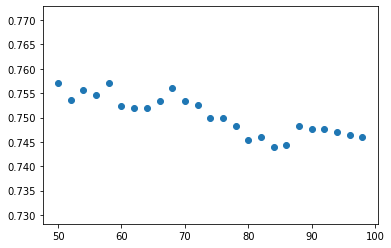

In [99]:
zip(*cv_scores_next)
plt.scatter(*zip(*cv_scores_next))
plt.show()

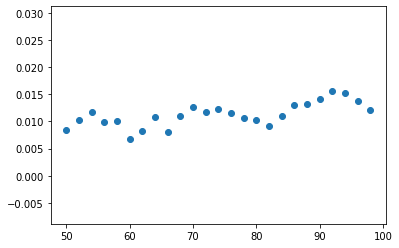

In [100]:
zip(*cv_std_next)
plt.scatter(*zip(*cv_std_next))
plt.show()

In [106]:
print(cv_scores)

[(1, 0.7603333333333333), (3, 0.7516666666666667), (5, 0.7619999999999999), (7, 0.7699999999999999), (9, 0.7656666666666666), (11, 0.7676666666666667), (13, 0.772), (15, 0.7683333333333333), (17, 0.7653333333333332), (19, 0.764), (21, 0.765), (23, 0.7673333333333334), (25, 0.7673333333333334), (27, 0.7633333333333334), (29, 0.7633333333333333), (31, 0.7656666666666666), (33, 0.7623333333333333), (35, 0.7606666666666666), (37, 0.7643333333333333), (39, 0.767), (41, 0.7653333333333333), (43, 0.764), (45, 0.7596666666666666), (47, 0.7586666666666666), (49, 0.7596666666666667)]


Test 12 and 14 now. k=3 seems to be the best

In [107]:
# creating odd list of K for KNN
neighbors = list(range(12, 15, 1))

# empty list that will hold cv scores
cv_scores_mid = []
cv_std_mid = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xtrain, Ytrain, cv=skf, scoring='accuracy')
    cv_scores_mid.append((k,scores.mean()))
    cv_std_mid.append((k,scores.std()))

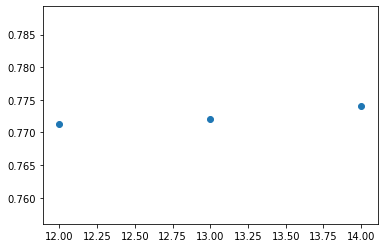

[(12, 0.7713333333333333), (13, 0.772), (14, 0.774)]


In [109]:
zip(*cv_scores_mid)
plt.scatter(*zip(*cv_scores_mid))
plt.show()
print(cv_scores_mid)

so choose k=14

In [13]:
# creating odd list of K for KNN
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
cv_scores_def = []
cv_std_def = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xtrain, Ytrain, cv=skf, scoring='accuracy')
    cv_scores_def.append((k,scores.mean()))
    cv_std_def.append((k,scores.std()))

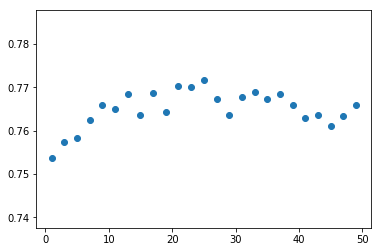

[(1, 0.7536536194082021), (3, 0.7573208314467539), (5, 0.7583297314714763), (7, 0.7623291823958771), (9, 0.7659947435039172), (11, 0.7649952907276595), (13, 0.7683319666628704), (15, 0.7636652944406327), (17, 0.7686630833233796), (19, 0.7643314175872711), (21, 0.7703303064730735), (23, 0.7699941981320318), (25, 0.7716569749730786), (27, 0.767329193507019), (29, 0.7636664074066872), (31, 0.767663630547122), (33, 0.7689964092492849), (35, 0.7673330777770679), (37, 0.7683314064761292), (39, 0.7659969620285982), (41, 0.762996401841857), (43, 0.7636641759190071), (45, 0.760996398138143), (47, 0.7633319574035854), (49, 0.7660008500023612)]


In [14]:
zip(*cv_scores_def)
plt.scatter(*zip(*cv_scores_def))
plt.show()
print(cv_scores_def)

In [15]:
# creating odd list of K for KNN
neighbors = list(range(19, 28, 1))

# empty list that will hold cv scores
cv_scores_zoom = []
cv_std_zoom = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xscale, Ytrain, cv=skf, scoring='accuracy')
    cv_scores_zoom.append((k,scores.mean()))
    cv_std_zoom.append((k,scores.std()))

## Question 3

### Perceptron

In [20]:
perceptron = Perceptron(random_state = 0)

# IF y if binary or multiclass, Statified is used once cv=n is specified
perceptron_scores = cross_val_score(perceptron, Xscale, Ytrain, cv=5)
print(perceptron_scores.mean(), perceptron_scores.std())

0.6346668601857226 0.03916055404005618


/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Per

In [21]:
print(perceptron_scores)

[0.67387687 0.605      0.575      0.645      0.67445743]


In [4]:
from sklearn.svm import SVC

LSVM = SVC(C = 1.0, class_weight = 'balanced', kernel = 'linear')

#scores = cross_val_score(LSVM, Xtrain, Ytrain, cv=5)
#print(scores)

#Zp = LSVM.decision_function(Xtrain)


NameError: name 'Ypredict' is not defined

In [35]:
LSVM.fit(Xscale,Ytrain)
Ypredict = LSVM.predict(Xscale)

print( "Train Accuracy", np.mean(Ypredict==Ytrain))

Train Accuracy 0.8663333333333333


In [36]:
LSVMscore = cross_val_score(LSVM, Xscale, Ytrain, cv=5)
print(LSVMscore)

[0.65723794 0.66333333 0.64166667 0.67       0.71452421]


In [ ]:
polySVM = SVC(C = 1, kernel = 'poly', degree = 2,  class_weight = 'balanced', coef0 = 1.0)

polySVM_score = cross_val_score(polySVM, Xscale, Ytrain, cv = 5)

In [13]:
print(polySVM_score)
polySVM_score.mean()

[0.78369384 0.77833333 0.79       0.77166667 0.78964942]


0.7826686518573662

In [14]:
polySVM4 = SVC(C = 1, kernel = 'poly', degree = 4,  class_weight = 'balanced', coef0 = 1.0)

polySVM4_score = cross_val_score(polySVM4, Xscale, Ytrain, cv = 5)

/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/loc

In [15]:
print(polySVM4_score)
polySVM4_score.mean()

[0.77204659 0.77333333 0.77833333 0.77833333 0.78964942]


0.7783392009422248